# Convolutional Neural Nets

This type of neural nets are predominantly (and heavily) used in image processing.

## Useful terms:

1. Convolution
2. Max pooling
2. Softmax
3. Cross Entropy

## Further Readings:
https://ujjwalkarn.me/2016/08/11/intuitive-explanation-convnets/

In [2]:
from IPython.display import HTML

HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/BcEapJEKz3M?rel=0&amp;controls=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe>')


In [1]:
!pip install tqdm

    100% |################################| 51kB 1.5MB/s ta 0:00:01


In [2]:
import numpy as np
import matplotlib.pyplot as plt

from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
# import problem_unittests as tests
import tarfile
import pickle

from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPool2D, Flatten, BatchNormalization

%matplotlib inline

Using Theano backend.


In [3]:
cifar10_dataset_folder_path = 'cifar-10-batches-py'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile('cifar-10-python.tar.gz'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            'cifar-10-python.tar.gz',
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open('cifar-10-python.tar.gz') as tar:
        tar.extractall()
        tar.close()
        
label_dict = dict(zip(range(10), 
                      ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']))  
width = height = 32
channels = 3
train_examples = 50000

# Get the test set
with open(cifar10_dataset_folder_path + '/test_batch', mode='rb') as file:
    batch = pickle.load(file, encoding='latin1')

    test_x = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)/255
    test_y = batch['labels']

In [4]:
def get_batch(batch_size):
    n_batches = 5
    while(1):
        for batch_id in range(1, n_batches + 1):
            with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id), mode='rb') as file:
                batch = pickle.load(file, encoding='latin1')

                features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
                labels = batch['labels']
                for start in range(0, len(features), batch_size):
                    end = min(start + batch_size, len(features))
                    yield features[start:end]/255, np.array(labels[start:end])

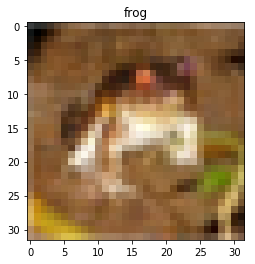

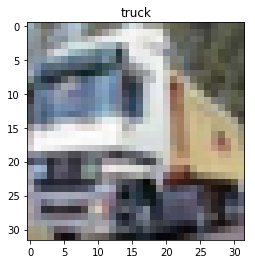

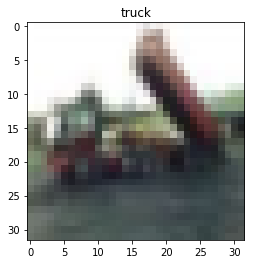

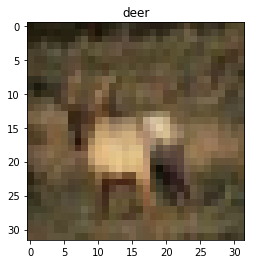

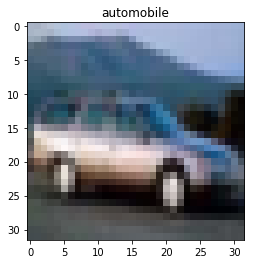

In [5]:
x, y = next(get_batch(5))
for im, label in zip(x,y):
    plt.imshow(im)
    plt.title(label_dict[label])
    plt.show()

## Basic logistic multiclass classification:

In [6]:
batch_size = 1000
gen = get_batch(batch_size)
x_train, y_train = next(gen)

In [7]:
from sklearn.linear_model import LogisticRegression
logistic = LogisticRegression()
logistic.fit(x_train.reshape(batch_size,-1), y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [8]:
y_pred = logistic.predict(test_x.reshape(len(test_x), -1))
y_pred[:10]

array([6, 1, 8, 0, 4, 3, 3, 6, 1, 1])

Predicting the probabilities for the first 3 images:

In [9]:
logistic.predict_proba(test_x[:3].reshape(3,-1))

array([[  5.11780589e-02,   5.22601998e-02,   1.55926385e-01,
          1.91240503e-01,   3.91236477e-04,   1.54297967e-01,
          2.80945273e-01,   1.19926488e-06,   1.13659809e-01,
          9.93687013e-05],
       [  2.16303715e-02,   7.31044039e-01,   2.69961983e-03,
          1.05058501e-01,   4.19521439e-04,   4.01069801e-03,
          7.30693763e-06,   2.05908231e-04,   2.05482815e-02,
          1.14375752e-01],
       [  6.08332707e-02,   8.16219690e-02,   7.55828475e-03,
          1.26261683e-01,   2.92891682e-02,   9.79890820e-03,
          7.44308146e-03,   4.27092877e-03,   6.19882712e-01,
          5.30399941e-02]])

Accuracy of the predictions:

In [10]:
np.count_nonzero(y_pred == test_y)/len(test_y)

0.275

The number of parameters for a fully connected network:

In [11]:
32*32*3*10

30720

## Keras Multilayered Perceptron (Neural Net)

In [12]:
def get_batch(batch_size):
    n_batches = 5
    while(1):
        for batch_id in range(1, n_batches + 1):
            with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id), mode='rb') as file:
                batch = pickle.load(file, encoding='latin1')

                features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
                labels = batch['labels']
                for start in range(0, len(features), batch_size):
                    end = min(start + batch_size, len(features))
                    x = features[start:end]/255
                    y = labels[start:end]
                    yield x.reshape(len(x),-1), np.array(y)

It is important to note that when we do classification problems we use the **Categorical Crossentropy Loss**. When its only two classes we can use Logistic Loss (Binary Crossentropy Loss). Finally for regression problems we use **Mean Squared Error**.

The Cross Entropy loss is defined as:
$$\mathcal{L} = -\frac{1}{N}\sum_i \mathcal{I}(y_i=1)\log(p_{i1})+\mathcal{I}(y_i=2)\log(1-p_{i2})+\cdots++\mathcal{I}(y_i=K)\log(1-p_{iK})$$
where $N$ is the number of training instances, $K$ is the number of classes and $p_{ik}$ is the probability that instance $i$ belongs to $k$.

Softmax takes a $D$ dimensional vector and squeezes them through a function such that we have $D$ outputs whos values are positive and sums to one.
$$
\text{softmax}(\mathbf{y})_d = \frac{\exp(-y_d)}{\exp(-y_1)+...+\exp(-y_D)}
$$

### 1 Hidden Layer

In [27]:
y[:10]

array([6, 9, 9, 4, 1])

In [ ]:
0 0 0 0 0 0 1 0 0 

In [13]:
model = Sequential()
model.add(Dense(units=100, input_dim=width*height*channels, activation='relu'))
model.add(Dense(units=10, activation='softmax'))
model.compile(optimizer='adadelta', loss='sparse_categorical_crossentropy')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               307300    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 308,310.0
Trainable params: 308,310
Non-trainable params: 0.0
_________________________________________________________________


In [14]:
batch_size = 256
model.fit_generator(get_batch(batch_size=batch_size), train_examples//batch_size, epochs=1)

Epoch 1/1
195/195 [==============================] - 3s - loss: 2.0425     


In [15]:
y_pred = model.predict_classes(test_x.reshape(len(test_x),-1))
np.count_nonzero(y_pred == test_y)/len(test_y)

 9728/10000 [============================>.] - ETA: 0s

0.3412

## Convolution Neural Networks (CNN)

** Points to note **
1. One CNN, connected to **one** node above is simply a Dense layer with most weights set to zero.
2. The same CNN, connected to multiple nodes is weight tying/ sharing.

Consider the following convolution mask:
<img src='https://ujwlkarn.files.wordpress.com/2016/07/screen-shot-2016-07-24-at-11-25-24-pm.png?w=74&h=64'>
<img src='https://ujwlkarn.files.wordpress.com/2016/07/convolution_schematic.gif?w=536&h=392'>

![](cnn.png)

In [16]:
def get_batch(batch_size):
    n_batches = 5
    while(1):
        for batch_id in range(1, n_batches + 1):
            with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id), mode='rb') as file:
                batch = pickle.load(file, encoding='latin1')

                features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
                labels = batch['labels']
                for start in range(0, len(features), batch_size):
                    end = min(start + batch_size, len(features))
                    x = features[start:end]/255
                    y = labels[start:end]
                    yield x, np.array(y)

### Using the max pooling layer:

In [17]:
model = Sequential()
model.add(Conv2D(8, kernel_size=(3,3), padding='same', activation='relu', input_shape = (width,height,channels)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(16, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))
model.compile(optimizer='adadelta', loss='sparse_categorical_crossentropy')

In [18]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 8)         224       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 16)        1168      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 16)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 32)          4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
__________

In [19]:
batch_size = 256
model.fit_generator(get_batch(batch_size=batch_size), train_examples//batch_size, epochs=15)

Epoch 1/15
195/195 [==============================] - 31s - loss: 2.0763    
Epoch 2/15
195/195 [==============================] - 32s - loss: 1.7705    
Epoch 3/15
195/195 [==============================] - 34s - loss: 1.6121    
Epoch 4/15
195/195 [==============================] - 37s - loss: 1.5431    
Epoch 5/15
195/195 [==============================] - 37s - loss: 1.5011    
Epoch 6/15
195/195 [==============================] - 36s - loss: 1.4731    
Epoch 7/15
195/195 [==============================] - 32s - loss: 1.4511    
Epoch 8/15
195/195 [==============================] - 31s - loss: 1.4312    
Epoch 9/15
195/195 [==============================] - 33s - loss: 1.4157    
Epoch 10/15
195/195 [==============================] - 34s - loss: 1.4000    
Epoch 11/15
195/195 [==============================] - 36s - loss: 1.3849    
Epoch 12/15
195/195 [==============================] - 36s - loss: 1.3716    
Epoch 13/15
195/195 [==============================] - 33s - loss: 1.3587

In [20]:
y_pred = model.predict_classes(test_x)
np.count_nonzero(y_pred == test_y)/len(test_y)

 9920/10000 [============================>.] - ETA: 0s

0.5234

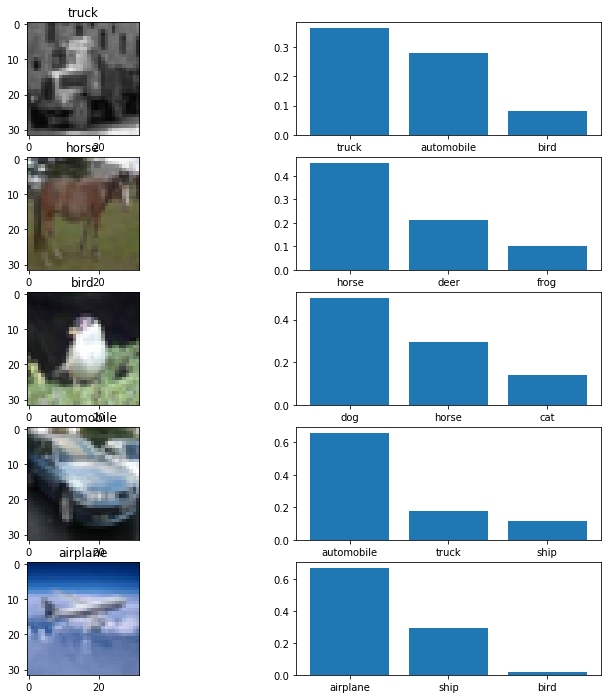

In [21]:
plt.figure(figsize=(12,12))
idx = np.random.choice(len(test_x),5,replace=False)


p = model.predict(test_x[idx])
for i in range(len(idx)):
    plt.subplot(5,2,2*i+1)
    plt.imshow(test_x[idx[i]])
    plt.title(label_dict[test_y[idx[i]]])
#     plt.show()
    pred_label = np.argsort(-p[i])[:3]
    pred_prob = [p[i][l] for l in pred_label]
    pred_label = [label_dict[l] for l in pred_label]
    
    plt.subplot(5,2,2*i+2)
    plt.bar(range(3),pred_prob)
    plt.xticks(range(3), pred_label)
#     plt.show()

plt.show()

## Batch Normalization

Batch Normalization makes the output of multiplying by weights 0 mean and variance of one **before** passing through an activation layer. This makes sure that the gradients are neither large or too small. Making the learning process faster. 

https://www.quora.com/Why-does-batch-normalization-help

In [22]:
model = Sequential()
model.add(Conv2D(8, kernel_size=(3,3), padding='same', input_shape = (width,height,channels)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(16, kernel_size=(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(32, kernel_size=(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))
model.compile(optimizer='adadelta', loss='sparse_categorical_crossentropy')

In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 8)         224       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 8)         0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 16)        1168      
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 16)        64        
_________________________________________________________________
activation_2 (Activation)    (None, 16, 16, 16)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 16)          0         
__________

In [24]:
batch_size = 256
model.fit_generator(get_batch(batch_size=batch_size), train_examples//batch_size, epochs=15)

Epoch 1/15
195/195 [==============================] - 45s - loss: 1.9342    
Epoch 2/15
195/195 [==============================] - 51s - loss: 1.5972    
Epoch 3/15
195/195 [==============================] - 51s - loss: 1.4710    
Epoch 4/15
195/195 [==============================] - 50s - loss: 1.3979    
Epoch 5/15
195/195 [==============================] - 50s - loss: 1.3430    
Epoch 6/15
195/195 [==============================] - 50s - loss: 1.2985    
Epoch 7/15
195/195 [==============================] - 50s - loss: 1.2603    
Epoch 8/15
195/195 [==============================] - 50s - loss: 1.2246    
Epoch 9/15
195/195 [==============================] - 48s - loss: 1.1945    
Epoch 10/15
195/195 [==============================] - 51s - loss: 1.1650    
Epoch 11/15
195/195 [==============================] - 56s - loss: 1.1407    
Epoch 12/15
195/195 [==============================] - 48s - loss: 1.1179    
Epoch 13/15
195/195 [==============================] - 53s - loss: 1.0988

In [25]:
y_pred = model.predict_classes(test_x)
np.count_nonzero(y_pred == test_y)/len(test_y)

 9888/10000 [============================>.] - ETA: 0s

0.5948

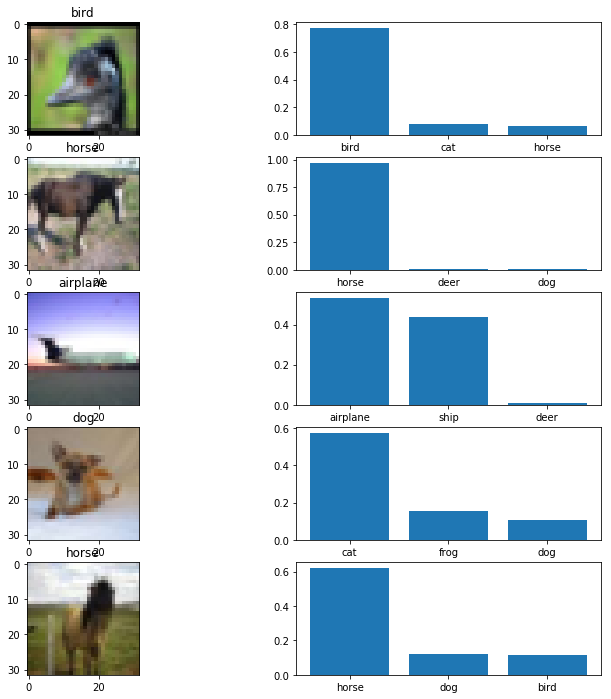

In [26]:
plt.figure(figsize=(12,12))
idx = np.random.choice(len(test_x),5,replace=False)


p = model.predict(test_x[idx])
for i in range(len(idx)):
    plt.subplot(5,2,2*i+1)
    plt.imshow(test_x[idx[i]])
    plt.title(label_dict[test_y[idx[i]]])
#     plt.show()
    pred_label = np.argsort(-p[i])[:3]
    pred_prob = [p[i][l] for l in pred_label]
    pred_label = [label_dict[l] for l in pred_label]
    
    plt.subplot(5,2,2*i+2)
    plt.bar(range(3),pred_prob)
    plt.xticks(range(3), pred_label)
#     plt.show()

plt.show()